# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Описание данных**

Данные находятся в файле _/datasets/Churn.csv_ (англ. «отток клиентов»).
Признаки

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак

- Exited — факт ухода клиента


**Оглавление**

1. [Подготовка данных](#step_1)
2. [Исследование задачи](#step_2)
3. [Борьба с дисбалансом](#step_3)
4. [Тестирование модели](#step_4)

# 1. Подготовка данных
<a id="step_1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
from sklearn.utils import shuffle

In [2]:
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('/datasets/Churn.csv')

In [4]:
df.sample(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
35,36,15794171,Lombardo,475,France,Female,45,0.0,134264.04,1,1,0,27822.99,1
8391,8392,15579074,Obiajulu,619,Germany,Male,38,10.0,84651.79,1,1,1,184754.26,0
5998,5999,15644212,Han,644,Spain,Male,28,0.0,0.00,2,1,0,119419.37,0
1213,1214,15624229,Noble,694,France,Female,22,4.0,0.00,2,1,1,11525.72,0
1827,1828,15740104,Tuan,425,Spain,Female,22,7.0,169649.73,2,0,1,136365.00,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
len(df['CustomerId'].unique()) == df.shape[0]

True

In [7]:
df = df.drop(['RowNumber', 'Surname'], axis=1)

In [8]:
df.set_index(['CustomerId'], inplace=True)

In [9]:
df.sample(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,
15635240,553,France,Male,42,1.0,0.00,2,0,0,23822.04,0
15653572,673,Spain,Male,43,NaN,127132.96,1,0,1,6009.27,1
15698839,460,Germany,Male,46,NaN,127559.97,2,1,1,126952.50,0
15715199,568,Spain,Male,27,5.0,126815.97,2,0,1,118648.12,0
15627971,504,France,Female,32,NaN,206663.75,1,0,0,16281.94,0


In [10]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [11]:
df.isna().sum()

CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [12]:
df.query('Tenure.isna()').sample(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,
15644453,606,Germany,Female,41,NaN,132670.53,1,1,0,156476.36,1
15600258,701,France,Male,43,NaN,0.00,2,1,1,165303.79,0
15604355,519,France,Male,39,NaN,97700.02,1,1,1,30709.03,0
15724145,616,Germany,Male,29,NaN,149318.55,1,1,0,140746.13,0
15668385,642,France,Male,40,NaN,154863.15,1,1,1,138052.51,0
15704160,648,Spain,Male,49,NaN,0.00,1,1,0,149946.43,1
15678779,502,France,Male,33,NaN,0.00,2,0,1,4082.52,0
15595136,645,France,Female,37,NaN,0.00,2,1,1,68987.55,0
15815690,614,Spain,Female,40,NaN,113348.50,1,1,1,77789.01,0


In [13]:
df = df.dropna(subset=['Tenure'])

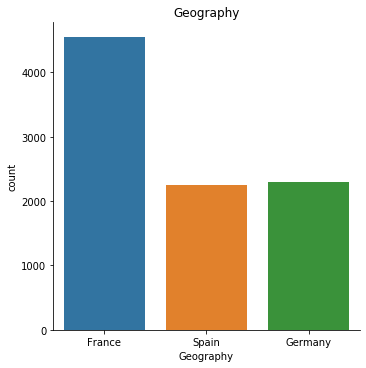

In [14]:
sns.catplot(x='Geography', data=df, kind='count').set(title='Geography', xlabel='Geography', ylabel='count')
plt.show()

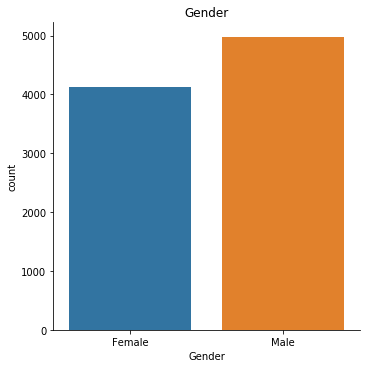

In [15]:
sns.catplot(x='Gender', data=df, kind='count').set(title='Gender', xlabel='Gender', ylabel='count')
plt.show()

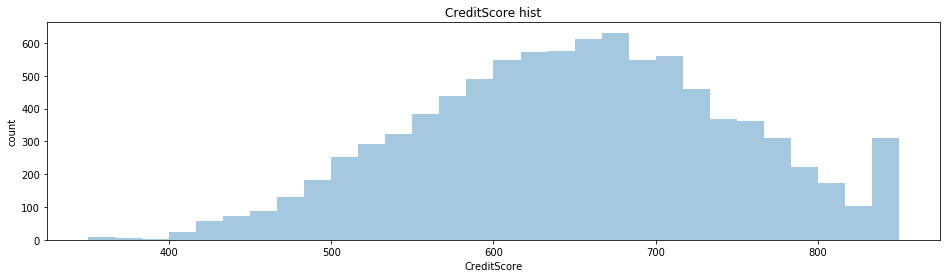

In [16]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(df['CreditScore'], kde=False, bins=30).set(title='CreditScore hist', xlabel='CreditScore', ylabel='count')
plt.show()

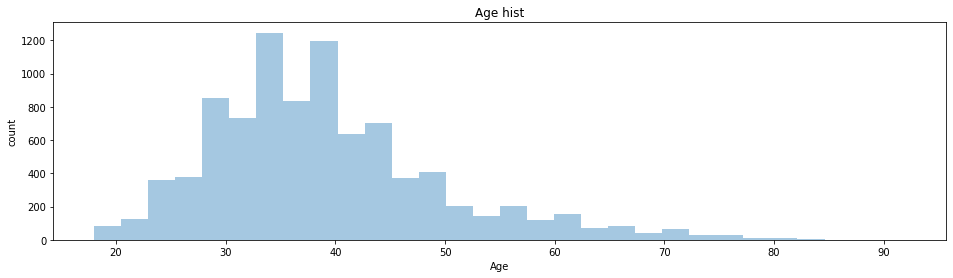

In [17]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(df['Age'], kde=False, bins=30).set(title='Age hist', xlabel='Age', ylabel='count')
plt.show()

In [18]:
df['Tenure'].value_counts().sort_index()

0.0     382
1.0     952
2.0     950
3.0     928
4.0     885
5.0     927
6.0     881
7.0     925
8.0     933
9.0     882
10.0    446
Name: Tenure, dtype: int64

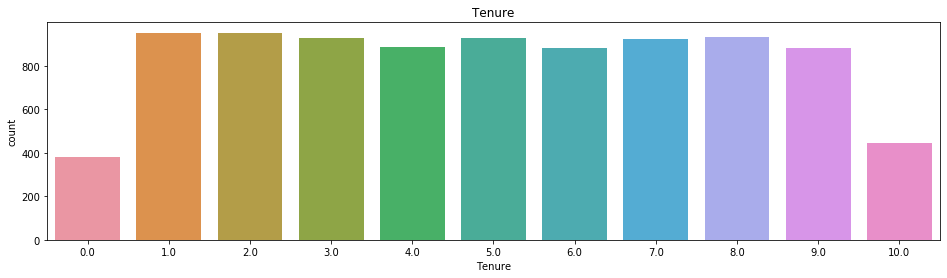

In [19]:
fig = plt.figure(figsize=(16, 4))
sns.countplot(df['Tenure']).set(title='Tenure')
plt.show()

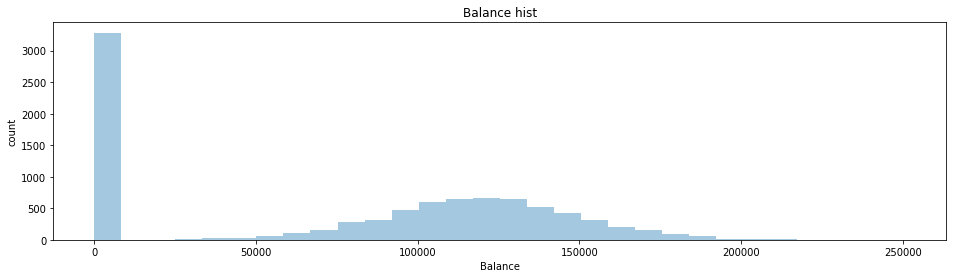

In [20]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(df['Balance'], kde=False, bins=30).set(title='Balance hist', xlabel='Balance', ylabel='count')
plt.show()

In [21]:
df['NumOfProducts'].value_counts()

1    4617
2    4184
3     234
4      56
Name: NumOfProducts, dtype: int64

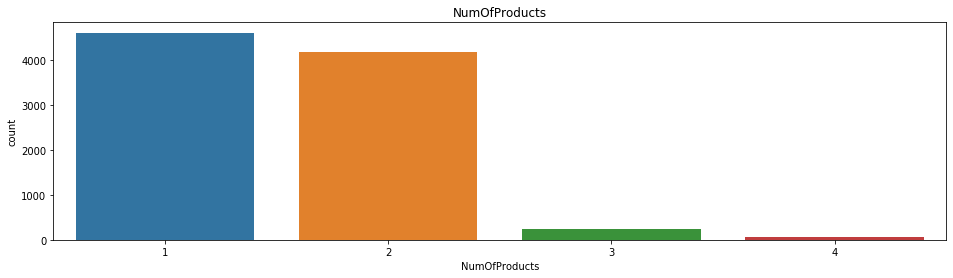

In [22]:
fig = plt.figure(figsize=(16, 4))
sns.countplot(df['NumOfProducts']).set(title='NumOfProducts')
plt.show()

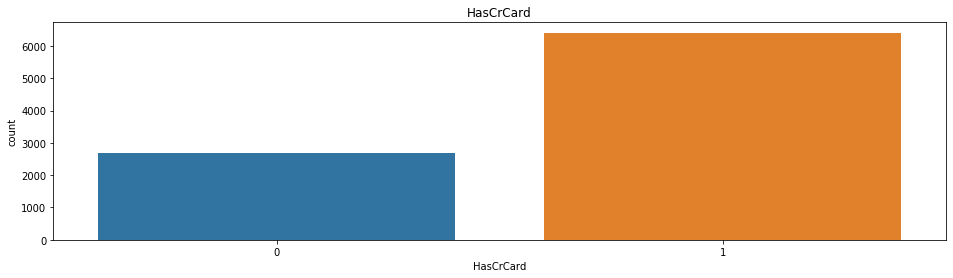

In [23]:
fig = plt.figure(figsize=(16, 4))
sns.countplot(df['HasCrCard']).set(title='HasCrCard')
plt.show()

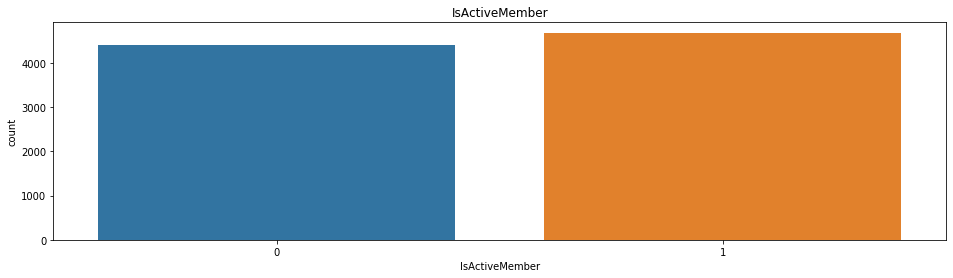

In [24]:
fig = plt.figure(figsize=(16, 4))
sns.countplot(df['IsActiveMember']).set(title='IsActiveMember')
plt.show()

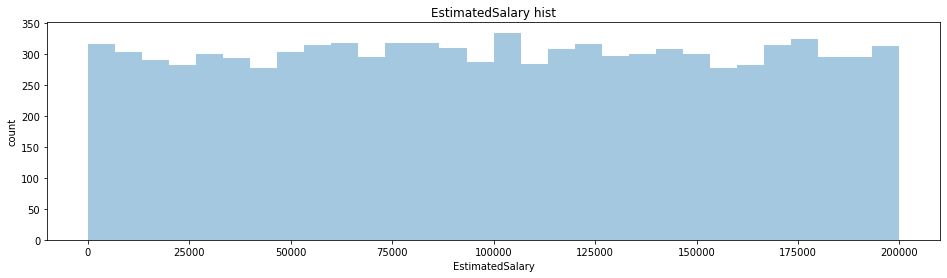

In [25]:
fig = plt.figure(figsize=(16, 4))
sns.distplot(df['EstimatedSalary'], kde=False, bins=30).set(title='EstimatedSalary hist', xlabel='EstimatedSalary', ylabel='count')
plt.show()

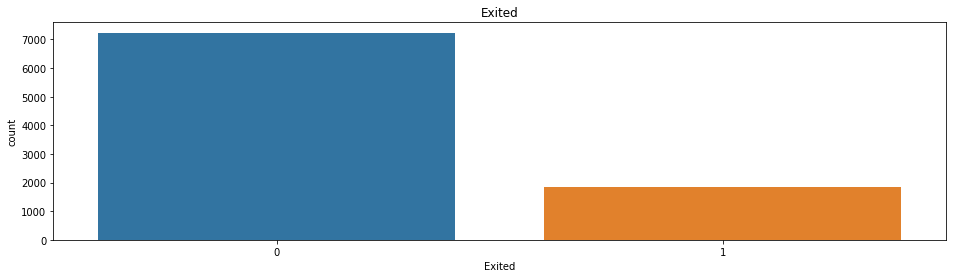

In [26]:
plt.figure(figsize=(16, 4))
sns.countplot(x='Exited', data=df).set(title='Exited')
plt.show()

In [27]:
df[df['Exited'] == 0].shape[0] / df[df['Exited'] == 1].shape[0]

3.9034519956850056

In [28]:
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

In [29]:
df.sample(5)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
CustomerId,,,,,,,,,,,,
15570192,608,40,8.0,121729.42,1,0,0,61164.45,0,1,0,0
15754494,585,33,4.0,152805.05,1,1,0,63239.65,0,0,0,0
15569670,627,30,6.0,112372.96,1,1,1,118029.09,0,1,0,1
15689061,611,68,5.0,82547.11,2,1,1,146448.01,0,0,0,1
15711299,711,52,8.0,145262.54,1,0,1,131473.31,0,1,0,0


In [30]:
features = df.drop(['Exited'], axis=1)
target = df['Exited']

features, target = shuffle(features, target, random_state=12345)

In [31]:
features_train, features_tt, target_train, target_tt = train_test_split(
    features, 
    target, 
    test_size=0.4, 
    random_state=12345
)

In [32]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_tt, 
    target_tt, 
    test_size=0.5, 
    random_state=12345
)

In [33]:
features_train.shape[0] + features_valid.shape[0] + features_test.shape[0] == features.shape[0]

True

Мы загрузили данные. У нас 10000 клиентов. Т.к. у нас есть уникальный идентификатор клиента CustomerId, то сделали его индексом, а лишние данные удалили (RowNumber, Surname).

У нас есть пропуски в кол-ве недвижимости. Удалили строки с пропуском. 35% клиентов с нулевым балансом на счете. Клиентов ушедших почти в 4 раза меньше оставшихся.

Два категориальных признака Страна проживания и Пол преобразуем в численные техникой OHE (One-Hot Encoding, прямое кодирование), удалив один столбец, т.к. оставшихся достаточно для восстановления значения удаленного столбца.

Мы поделили данные на тренировочные, валидационные и тестовые в соотношении 3:1:1.

# 2. Исследование задачи
<a id="step_2"></a>

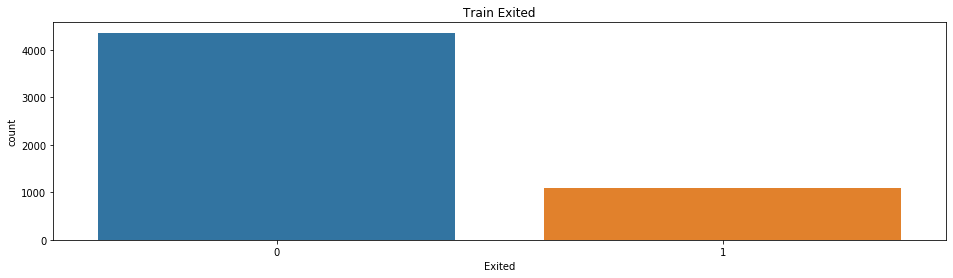

In [34]:
plt.figure(figsize=(16, 4))
sns.countplot(target_train).set(title='Train Exited')
plt.show()

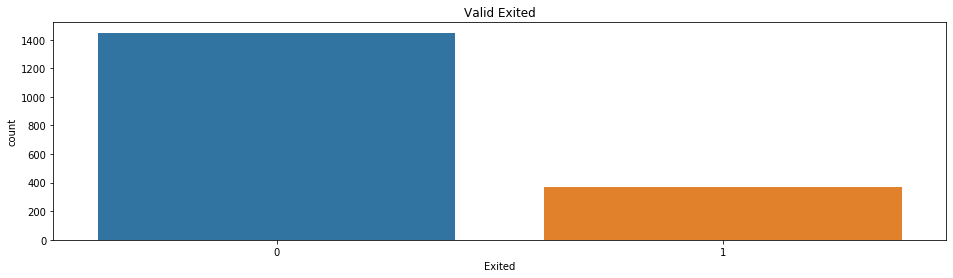

In [35]:
plt.figure(figsize=(16, 4))
sns.countplot(target_valid).set(title='Valid Exited')
plt.show()

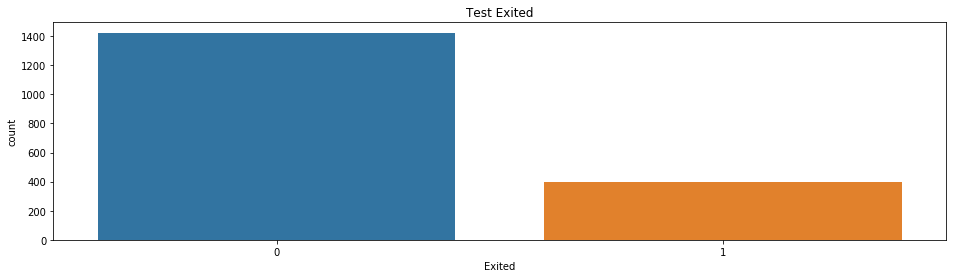

In [36]:
plt.figure(figsize=(16, 4))
sns.countplot(target_test).set(title='Test Exited')
plt.show()

### Логистическая регрессия

In [37]:
%%time

LR_model = LogisticRegression(random_state=12345, solver='liblinear')
LR_model.fit(features_train, target_train)

LR_predictions = LR_model.predict(features_valid)
LR_precision_score = precision_score(target_valid, LR_predictions)
LR_recall_score = recall_score(target_valid, LR_predictions)
LR_f1_score = f1_score(target_valid, LR_predictions)
LR_roc_auc = roc_auc_score(target_valid, LR_predictions)

# сохраним результаты в табличку
models = pd.DataFrame({
    'model':['LogisticRegression'], 
    'f1_score':[LR_f1_score], 
    'roc_auc':[LR_roc_auc]
})

print(f'LogisticRegression:')
print(f'F1 Score = {LR_f1_score}')
print(f'AUC-ROC = {LR_roc_auc}')
print(f'Точность = {LR_precision_score}')
print(f'Полнота = {LR_recall_score}')
print()

LogisticRegression:
F1 Score = 0.11594202898550725
AUC-ROC = 0.5252739483916579
Точность = 0.5333333333333333
Полнота = 0.06504065040650407

CPU times: user 89.1 ms, sys: 54.2 ms, total: 143 ms
Wall time: 92.8 ms


### Случайный лес

In [38]:
%%time

RF_model = None
best_depth = 0
best_est = 0
best_RF_f1_score = 0

for est in range(10,100,10):
    for depth in range(2,20,2):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        
        RF_predictions = model.predict(features_valid)
        RF_f1_score = f1_score(target_valid, RF_predictions)
        
        if RF_f1_score > best_RF_f1_score:
            RF_model = model
            best_RF_f1_score = RF_f1_score
            best_depth = depth
            best_est = est

RF_predictions = RF_model.predict(features_valid)
RF_precision_score = precision_score(target_valid, RF_predictions)
RF_recall_score = recall_score(target_valid, RF_predictions)
RF_f1_score = f1_score(target_valid, RF_predictions)
RF_roc_auc = roc_auc_score(target_valid, RF_predictions)

models = models.append(
    pd.DataFrame({
        'model':['RandomForestClassifier'], 
        'f1_score':[RF_f1_score], 
        'roc_auc':[RF_roc_auc]}
    ), 
    ignore_index=True
)

print(f'RandomForestClassifier depth={best_depth}, estimators={best_est}')
print(f'F1 Score = {RF_f1_score}')
print(f'AUC-ROC = {RF_roc_auc}')
print(f'Точность = {RF_precision_score}')
print(f'Полнота = {RF_recall_score}')
print()

RandomForestClassifier depth=12, estimators=10
F1 Score = 0.5656565656565656
AUC-ROC = 0.7079735393627228
Точность = 0.7466666666666667
Полнота = 0.45528455284552843

CPU times: user 30.3 s, sys: 153 ms, total: 30.5 s
Wall time: 30.7 s


На всех выборках видим дисбаланс, положительных ответов ~4 меньше.

Логистическая регрессия вернула очень маленькое значение метрики F1 (0.11). Это связано с тем что данная модель плохо угадывает положительные отчеты (Полнота=0.06).

Случайный лес дал лучший результат по метрике F1 (0.56), т.к. полнота и точность значительно больше чем выдала модель логистической регрессии.

# 3. Борьба с дисбалансом
<a id="step_3"></a>

### Взвешивание классов

#### Логистическая регрессия

In [39]:
%%time

LR_model_balanced = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
LR_model_balanced.fit(features_train, target_train)

LR_predictions = LR_model_balanced.predict(features_valid)
LR_precision_score = precision_score(target_valid, LR_predictions)
LR_recall_score = recall_score(target_valid, LR_predictions)
LR_f1_score = f1_score(target_valid, LR_predictions)
LR_roc_auc = roc_auc_score(target_valid, LR_predictions)

models = models.append(
    pd.DataFrame({
        'model':['LogisticRegression Balanced'], 
        'f1_score':[LR_f1_score], 
        'roc_auc':[LR_roc_auc]}
    ), 
    ignore_index=True
)

print(f'LogisticRegression:')
print(f'F1 Score = {LR_f1_score}')
print(f'AUC-ROC = {LR_roc_auc}')
print(f'Точность = {LR_precision_score}')
print(f'Полнота = {LR_recall_score}')
print()

LogisticRegression:
F1 Score = 0.4794007490636704
AUC-ROC = 0.6940194246662964
Точность = 0.36623748211731044
Полнота = 0.6937669376693767

CPU times: user 110 ms, sys: 40.2 ms, total: 150 ms
Wall time: 119 ms


#### Случайный лес

In [40]:
%%time

RF_model_balanced = None
best_depth = 0
best_est = 0
best_RF_f1_score = 0

for est in range(10,100,10):
    for depth in range(2,20,2):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth, class_weight='balanced')
        model.fit(features_train, target_train)
        
        RF_predictions = model.predict(features_valid)
        RF_f1_score = f1_score(target_valid, RF_predictions)
        
        if RF_f1_score > best_RF_f1_score:
            RF_model_balanced = model
            best_RF_f1_score = RF_f1_score
            best_depth = depth
            best_est = est

RF_predictions = RF_model_balanced.predict(features_valid)
RF_precision_score = precision_score(target_valid, RF_predictions)
RF_recall_score = recall_score(target_valid, RF_predictions)
RF_f1_score = f1_score(target_valid, RF_predictions)
RF_roc_auc = roc_auc_score(target_valid, RF_predictions)

models = models.append(
    pd.DataFrame({
        'model':['RandomForestClassifier Balanced'], 
        'f1_score':[RF_f1_score], 
        'roc_auc':[RF_roc_auc]}
    ), 
    ignore_index=True
)

print(f'RandomForestClassifier depth={best_depth}, estimators={best_est}')
print(f'F1 Score = {RF_f1_score}')
print(f'AUC-ROC = {RF_roc_auc}')
print(f'Точность = {RF_precision_score}')
print(f'Полнота = {RF_recall_score}')
print()

RandomForestClassifier depth=6, estimators=60
F1 Score = 0.6297169811320755
AUC-ROC = 0.7886347186453232
Точность = 0.55741127348643
Полнота = 0.7235772357723578

CPU times: user 28.8 s, sys: 171 ms, total: 29 s
Wall time: 32.6 s


### Увеличение выборки

In [41]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [42]:
np.sum(target_train == 0) / np.sum(target_train == 1)

4.003669724770642

In [43]:
features_train_up, target_train_up = upsample(features_train, target_train, 4)

In [44]:
np.sum(target_train_up == 0) / np.sum(target_train_up == 1)

1.0009174311926605

#### Логистическая регрессия

In [45]:
%%time

LR_model_up = LogisticRegression(random_state=12345, solver='liblinear')
LR_model_up.fit(features_train_up, target_train_up)

LR_predictions = LR_model_up.predict(features_valid)
LR_precision_score = precision_score(target_valid, LR_predictions)
LR_recall_score = recall_score(target_valid, LR_predictions)
LR_f1_score = f1_score(target_valid, LR_predictions)
LR_roc_auc = roc_auc_score(target_valid, LR_predictions)

models = models.append(
    pd.DataFrame({
        'model':['LogisticRegression Upsampled'], 
        'f1_score':[LR_f1_score], 
        'roc_auc':[LR_roc_auc]}
    ), 
    ignore_index=True
)

print(f'LogisticRegression:')
print(f'F1 Score = {LR_f1_score}')
print(f'AUC-ROC = {LR_roc_auc}')
print(f'Точность = {LR_precision_score}')
print(f'Полнота = {LR_recall_score}')
print()

LogisticRegression:
F1 Score = 0.4458259325044405
AUC-ROC = 0.6655052264808363
Точность = 0.33157199471598414
Полнота = 0.6802168021680217

CPU times: user 124 ms, sys: 76.3 ms, total: 200 ms
Wall time: 208 ms


#### Случайный лес

In [46]:
%%time

RF_model_up = None
best_depth = 0
best_est = 0
best_RF_f1_score = 0

for est in range(10,100,10):
    for depth in range(2,20,2):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train_up, target_train_up)
        
        RF_predictions = model.predict(features_valid)
        RF_f1_score = f1_score(target_valid, RF_predictions)
        
        if RF_f1_score > best_RF_f1_score:
            RF_model_up = model
            best_RF_f1_score = RF_f1_score
            best_depth = depth
            best_est = est

RF_predictions = RF_model_up.predict(features_valid)
RF_precision_score = precision_score(target_valid, RF_predictions)
RF_recall_score = recall_score(target_valid, RF_predictions)
RF_f1_score = f1_score(target_valid, RF_predictions)
RF_roc_auc = roc_auc_score(target_valid, RF_predictions)

models = models.append(
    pd.DataFrame({
        'model':['RandomForestClassifier Upsampled'], 
        'f1_score':[RF_f1_score], 
        'roc_auc':[RF_roc_auc]}
    ), 
    ignore_index=True
)

print(f'RandomForestClassifier depth={best_depth}, estimators={best_est}')
print(f'F1 Score = {RF_f1_score}')
print(f'AUC-ROC = {RF_roc_auc}')
print(f'Точность = {RF_precision_score}')
print(f'Полнота = {RF_recall_score}')
print()

RandomForestClassifier depth=10, estimators=20
F1 Score = 0.6254826254826255
AUC-ROC = 0.7723324748775439
Точность = 0.5955882352941176
Полнота = 0.6585365853658537

CPU times: user 44.2 s, sys: 142 ms, total: 44.4 s
Wall time: 1min 31s


### Уменьшение выборки

In [47]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [48]:
np.sum(target_train == 1) / np.sum(target_train == 0)

0.24977085242896424

In [49]:
features_train_down, target_train_down = downsample(features_train, target_train, 0.25)

In [50]:
np.sum(target_train_down == 1) / np.sum(target_train_down == 0)

0.999083409715857

#### Логистическая регрессия

In [51]:
%%time

LR_model_down = LogisticRegression(random_state=12345, solver='liblinear')
LR_model_down.fit(features_train_down, target_train_down)

LR_predictions = LR_model_down.predict(features_valid)
LR_precision_score = precision_score(target_valid, LR_predictions)
LR_recall_score = recall_score(target_valid, LR_predictions)
LR_f1_score = f1_score(target_valid, LR_predictions)
LR_roc_auc = roc_auc_score(target_valid, LR_predictions)

models = models.append(
    pd.DataFrame({
        'model':['LogisticRegression Downsampled'], 
        'f1_score':[LR_f1_score], 
        'roc_auc':[LR_roc_auc]}
    ), 
    ignore_index=True
)

print(f'LogisticRegression:')
print(f'F1 Score = {LR_f1_score}')
print(f'AUC-ROC = {LR_roc_auc}')
print(f'Точность = {LR_precision_score}')
print(f'Полнота = {LR_recall_score}')
print()

LogisticRegression:
F1 Score = 0.4428697962798938
AUC-ROC = 0.6627699506808732
Точность = 0.32894736842105265
Полнота = 0.6775067750677507

CPU times: user 61.4 ms, sys: 60.3 ms, total: 122 ms
Wall time: 168 ms


#### Случайный лес

In [52]:
%%time

RF_model_down = None
best_depth = 0
best_est = 0
best_RF_f1_score = 0

for est in range(10,100,10):
    for depth in range(2,20,2):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train_down, target_train_down)
        
        RF_predictions = model.predict(features_valid)
        RF_f1_score = f1_score(target_valid, RF_predictions)
        
        if RF_f1_score > best_RF_f1_score:
            RF_model_down = model
            best_RF_f1_score = RF_f1_score
            best_depth = depth
            best_est = est

RF_predictions = RF_model_down.predict(features_valid)
RF_precision_score = precision_score(target_valid, RF_predictions)
RF_recall_score = recall_score(target_valid, RF_predictions)
RF_f1_score = f1_score(target_valid, RF_predictions)
RF_roc_auc = roc_auc_score(target_valid, RF_predictions)

models = models.append(
    pd.DataFrame({
        'model':['RandomForestClassifier Downsampled'], 
        'f1_score':[RF_f1_score], 
        'roc_auc':[RF_roc_auc]}
    ), 
    ignore_index=True
)

print(f'RandomForestClassifier depth={best_depth}, estimators={best_est}')
print(f'F1 Score = {RF_f1_score}')
print(f'AUC-ROC = {RF_roc_auc}')
print(f'Точность = {RF_precision_score}')
print(f'Полнота = {RF_recall_score}')
print()

RandomForestClassifier depth=8, estimators=60
F1 Score = 0.605927552140505
AUC-ROC = 0.7821963002238718
Точность = 0.5092250922509225
Полнота = 0.7479674796747967

CPU times: user 18.4 s, sys: 83.2 ms, total: 18.4 s
Wall time: 37.9 s


In [53]:
models.sort_values(by='f1_score', ascending=False)

,model,f1_score,roc_auc
3,RandomForestClassifier Balanced,0.629717,0.788635
5,RandomForestClassifier Upsampled,0.625483,0.772332
7,RandomForestClassifier Downsampled,0.605928,0.782196
1,RandomForestClassifier,0.565657,0.707974
2,LogisticRegression Balanced,0.479401,0.694019
4,LogisticRegression Upsampled,0.445826,0.665505
6,LogisticRegression Downsampled,0.442870,0.662770
0,LogisticRegression,0.115942,0.525274


### Вывод

По итоговой таблице результатов различных вариаций моделей видно, что лучший результат выдает модель Случайный лес с метрикой F1 = 0.62. Стоит так же отметить, что даже с дисбалансом Случайный лес выдает результат лучше чем Логистическая регрессия в любом виде.

В качестве основной модели возьмем Случаный лес (RF_model_balanced) со взвешиванием классов.

# 4. Тестирование модели
<a id="step_4"></a>

In [54]:
test_predictions = RF_model_balanced.predict(features_test)

test_precision_score = precision_score(target_test, test_predictions)
test_recall_score = recall_score(target_valid, RF_predictions)
test_f1_score = f1_score(target_valid, RF_predictions)
test_roc_auc = roc_auc_score(target_valid, RF_predictions)

print(f'F1 Score = {test_f1_score}')
print(f'AUC-ROC = {test_roc_auc}')
print()
print(f'Точность = {test_precision_score}')
print(f'Полнота = {test_recall_score}')

F1 Score = 0.605927552140505
AUC-ROC = 0.7821963002238718

Точность = 0.567287784679089
Полнота = 0.7479674796747967


### Вывод

Модель Случайный лес с гиперпараметрами Глубина: 6, Кол-во деревьев: 60. Модель обучалась со взвешиванием классов.

На скрытой тестовой выборке наша модель показала результат аналогично валидационной выборке:
- F1 = 0.60
- AUC-ROC = 0.78